# Lab 7 [$\aleph_0$]: an unbiased variable selection procedure

It's finally time to put everything together. We'll start by analyzing a real dataset using the traditional pipeline, as shown in the figure below, and see how it can fail due to some characteristics of the dataset.

We will then move on to a more sophisticated analysis pipeline to overcome those limitations.

![Supervised learning pipeline](supervised_learning_pipeline.png)

Main concepts:

 * Unbiased variable selection
 * Permutation test

## Imports and setup

The usual stuff:

 * Magic command `%matplotlib inline` so that plots are displayed correctly in the notebook.
 * `matplotlib` followed by `seaborn` in order to have fancy plots
 * `numpy` _et similia_ for number crunching.
 * `pandas` to read the dataset files which are in csv format 
 
Additional libraries will be imported whenever they are needed

In [114]:
%matplotlib inline

from __future__ import division

import matplotlib
from matplotlib import pyplot as plt

import seaborn

import numpy as np
import pandas as pd

## Dataset

This time we will use an actual dataset, the _Golub_ dataset from [[1]](https://www.ncbi.nlm.nih.gov/pubmed/10521349).
It consists of a total of 38 samples of patients affected by two different types of leukemia (ALL and AML). Each sample is represented by the expression levels of 7129 genes, so the size of the input matrix `X` will be a $38 \times 7129$.

In [115]:
data_file = 'data/gedm.csv'
labels_file = 'data/labels.csv'

data = pd.read_csv(data_file, index_col=0)
X = data.as_matrix().T # we need to transpose because of how the file is writtend

# Also extract feature names
feature_names = data.index

labels = pd.read_csv(labels_file, index_col=0)
y = labels.as_matrix().ravel()

In [116]:
# Retrieve the shape of the matrix
n, d = X.shape

# Shuffle the dataset manually
np.random.seed(3)
idx = np.arange(n)
np.random.shuffle(idx)

X = X[idx, :]
y = y[idx]

n4 = int(n/3)

idx_tr = idx[n4:] # indexes of training samples
idx_ts = idx[:n4] # indexes of test samples

X_tr = X[idx_tr, :]
X_ts = X[idx_ts, :]

y_tr = y[idx_tr]
y_ts = y[idx_ts]

Take a look at the nature of the labels vector `y`. As in, print it and see what are its components.

In [117]:
### BEGIN STUDENTS ###
### END STUDENTS ###

This was just to show you that it containst _string_ type objects. However, sklearn's methods are smart enough to recognize that there are only **two** different strings, and algorithms for classification work without any need to explicitly encode those strings into real values.

Now, let's proceed by training a model on the data.

<img style="float: left;" src="warning.png" width="20px"> &nbsp; **Warning**: Do not touch the configuration, as it is set to reproduce a particular result.

In [118]:
# Import algorithms for classification
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score

# Model selection
from sklearn.model_selection import GridSearchCV

# Set the estimator to be a GridSearchCV
param_grid = {
    'n_features_to_select': [10, 20, 50],
    'estimator__C': np.logspace(-4, 0, 5),
}

# STEP 1: Variable selection                                                                                                                                                                              
vs = RFE(LinearSVC(loss='hinge'), step=0.3)                                                                                                                                                               

grid_search = GridSearchCV(vs, param_grid=param_grid)
grid_search.fit(X_tr, y_tr)
y_pred = grid_search.predict(X_ts)

acc_score = accuracy_score(y_ts, y_pred)
print("Accuracy score: {}".format(acc_score))

Accuracy score: 0.75


We obtained an accuracy score of 0.75.

Question: _is it good_? Think about it. Ok, of course if I'm writing this it means that it's not good. 

New question (this time for real): _why_ it isn't good? Think about it for a couple of minutes.

SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   
SPOILERS   

Ok, now that we decided that it's not a good result, what do we do? I mean, do we accept it? However, if we do so it would mean to claim that there is no apparent relation between input and output, as if among those genes it's not possible to find any responsible for the disease.   
Which _could_ very well be the case, however are we sure we have ruled out all possible explanations for such a poor result?

The answer again is _no_.

The thing is, with so few samples in such a high dimensional space (38 vs 7219), the way we initially split our dataset in training and test set has a great impact on the results.

In order to cancel out the effect of randomness induced by the split, a solution is to _repeat_ the whole pipeline several times, each time splitting the dataset in two (slightly) different training and test set using _Monte Carlo resampling_.

To do so, we will use a `python` package developed by a beautiful PhD student, available at https://github.com/slipguru/palladio (you should already have it installed if you followed the instructions I gave you).

![Palladio](palladio_logo_npbg.png)

I can only provide a simple example, and don't really have time to go over all configuration options.

I'll give you the quick version: it works by repeating the pipeline many times so that we end up with a _distribution_ of accuracy values, rather than a single one. Moreover, it repeats the pipeline in a different setting, that is by randomly shuffling the labels **of the training set only**, in order to simulate a dataset in which we already know in advance there's nothing to find, as in the example in the previous lab. In the end, these two distributions are compared using a statistical test (the _two sample Kolmogorov Smirnov test_, which determines if two sets of values come from the same population, without any assumption over the shape of the distribution).    
As far as it concerns variable selection, every repetition of the pipeline will return a [possibly different] set o variables; by observing the selection frequency of the variables we may have a clearer idea of which are the relevant ones, without worrying about the randomness of the split.

In [119]:
# PALLADIO imports
import palladio
import palladio.analysis
import palladio.plotting

# Dataset stuff
from palladio import datasets


# Dataset loading
data_path = 'data/gedm.csv'
target_path = 'data/labels.csv'



data_loading_options = target_loading_options = {                                                                                                                                                                                  
    'delimiter': ',',                                                                                                                                                                                     
    'header': 0,                                                                                                                                                                                          
    'index_col': 0                                                                                                                                                                                        
}

dataset = datasets.load_csv(data_path, target_path,                                                                                                                                                       
                            data_loading_options=data_loading_options,                                                                                                                                    
                            target_loading_options=target_loading_options,                                                                                                                                
                            samples_on='col')                                                                                                                                                             
data, labels = dataset.data, dataset.target
feature_names = dataset.feature_names



<img style="float: left;" src="warning.png" width="20px"> &nbsp; **Warning**: In case you need to, change the `session_folder`.

In [120]:
# Subfolder where results will be saved
session_folder = '/tmp/results'

# The learning task, if None palladio tries to guess it
# [see sklearn.utils.multiclass.type_of_target]
learning_task = None

# Usually we would do more than 5 repetitions, but on a single machine it would take too much time
n_splits_permutation = 5
n_splits_regular = 5

In [121]:
# STEP 1: Variable selection                                                                                                                                                                              
vs = RFE(LinearSVC(loss='hinge'), step=0.3)                                                                                                                                                               

# Set the estimator to be a GridSearchCV
param_grid = {
    'n_features_to_select': [10, 20, 50],
    'estimator__C': np.logspace(-4, 0, 5),
}

estimator = GridSearchCV(vs, param_grid=param_grid, cv=3, scoring='accuracy')

# Set options for ModelAssessment
ma_options = {
    'test_size': 0.25,
    'scoring': 'accuracy',
    'n_jobs': -1,
    'n_splits': n_splits_regular
}

In [122]:
vs_analysis = True

frequency_threshold = 0.75

score_surfaces_options = {}

In [123]:
### Compose the configuration object

# TODO must fix
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
config_dict = {
    # Dataset
    'data' : data,
    'labels' : labels,
    'feature_names' : feature_names,
    # Session
    'session_folder' : session_folder,
    'learning_task' : learning_task,
    'n_splits_permutation' : n_splits_permutation,
    # Learning algorithm
    'estimator' : estimator,
    'param_grid' : param_grid,
    'ma_options' : ma_options,
    # Analysis
    'vs_analysis' : vs_analysis,
    'frequency_threshold' : frequency_threshold,
    'score_surfaces_options' : score_surfaces_options,
    
    
}

config = Struct(**config_dict)

## Experiment running

In [124]:
regular_batch, permutation_batch = palladio.job_distribution.main(config=config)

Loading dataset...
  * Data shape: (38, 7129)
  * Labels shape: (38,)


In [125]:
## Analysis

In [126]:
performance_regular = palladio.analysis.performance_metrics(
    regular_batch.cv_results_, 
    config.labels, 
    target='classification'
)

performance_permutation = palladio.analysis.performance_metrics(
    permutation_batch.cv_results_, 
    config.labels, 
    target='classification'
)

[accuracy_score] Two sample Kolmogorov-Smirnov test: Ks_2sampResult(statistic=0.80000000000000004, pvalue=0.03614619076928504)


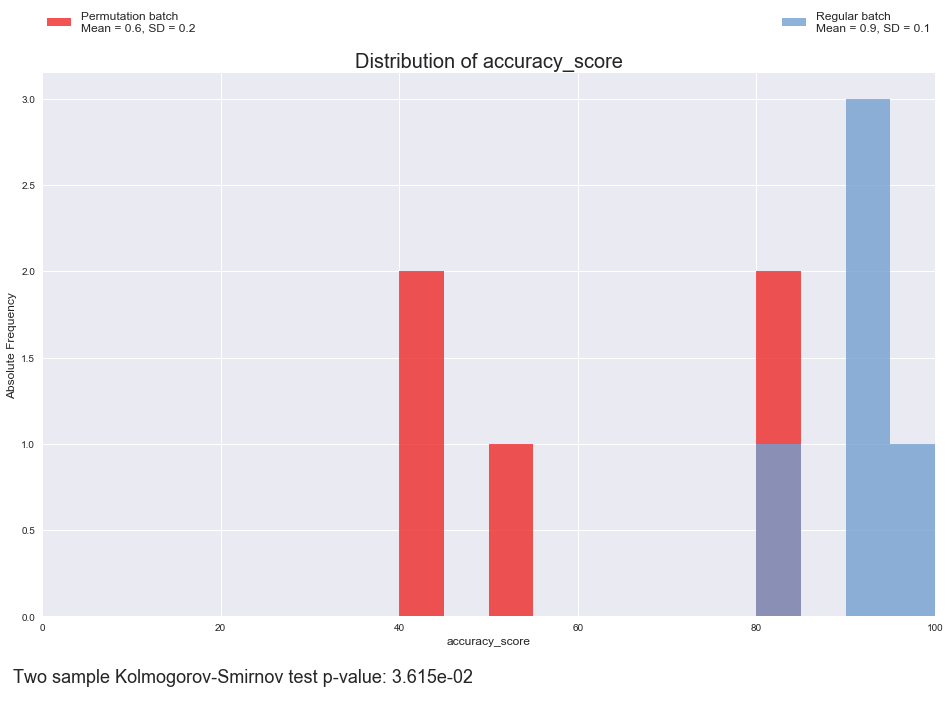

In [127]:
fig, ax1 = plt.subplots(figsize=(16, 10))

metric = 'accuracy_score'

palladio.plotting.distributions(
            v_regular=performance_regular[metric],
            v_permutation=performance_permutation[metric],
            fig=fig, ax=ax1,
            metric=metric
)

In [128]:
from palladio.utils import get_selected_list

from six import iteritems

selected = {}
# Init variable selection containers
selected['regular'] = dict(zip(feature_names,
                                       np.zeros(len(feature_names))))

feature_names = np.array(feature_names)

for b in range(n_splits_regular):
    f_idx = selected_feature_indices = get_selected_list(regular_batch.cv_results_['estimator'][b], True)
    f_names = feature_names[f_idx]
    for f in f_names:
    
        selected['regular'][f] += 1
      
feat_arr_r = np.array(list(iteritems(selected['regular'])), dtype=object)
feat_arr_r = feat_arr_r[feat_arr_r[:, 1].argsort()]
    
print(feat_arr_r[::-1][:100])

[['D21261_at' 5.0]
 ['M96326_rna1_at' 5.0]
 ['M27891_at' 5.0]
 ['Z19554_s_at' 5.0]
 ['M69043_at' 5.0]
 ['Y00787_s_at' 5.0]
 ['D49824_s_at' 5.0]
 ['M19507_at' 5.0]
 ['M17733_at' 5.0]
 ['Y00433_at' 4.0]
 ['L06797_s_at' 4.0]
 ['M14328_s_at' 4.0]
 ['L20941_at' 4.0]
 ['M14483_rna1_s_at' 4.0]
 ['X17042_at' 4.0]
 ['M91438_at' 4.0]
 ['M11147_at' 4.0]
 ['M63138_at' 4.0]
 ['X78992_at' 4.0]
 ['Z48501_s_at' 4.0]
 ['L19779_at' 4.0]
 ['M28130_rna1_s_at' 4.0]
 ['U06155_s_at' 4.0]
 ['M13792_at' 3.0]
 ['Z48950_at' 3.0]
 ['X56681_s_at' 3.0]
 ['HG1428-HT1428_s_at' 3.0]
 ['U51004_at' 3.0]
 ['X04085_rna1_at' 3.0]
 ['X15183_at' 3.0]
 ['hum_alu_at' 3.0]
 ['M24485_s_at' 3.0]
 ['M25079_s_at' 3.0]
 ['Z23090_at' 3.0]
 ['M33680_at' 3.0]
 ['U05259_rna1_at' 3.0]
 ['M19045_f_at' 3.0]
 ['HG3576-HT3779_f_at' 3.0]
 ['Z84721_cds2_at' 3.0]
 ['HG2887-HT3031_at' 3.0]
 ['AFFX-HUMRGE/M10098_5_at' 2.0]
 ['X98482_r_at' 2.0]
 ['M14199_s_at' 2.0]
 ['X14008_rna1_f_at' 2.0]
 ['M92843_s_at' 2.0]
 ['L20688_at' 2.0]
 ['M91036_rna1_at

We did too few experiments to get meaningful feature selection frequencies, however this is how a plot of the top $2 \times M$ features (where M is the number of features whose selection frequency is above a fixed threshold) would look like.

![Palladio](feature_frequencies.png)